In [30]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 

class KNNClassifier:
    k = None
    encoded_train_data = pd.DataFrame()
    
    def find_one_hot_encoding(self,train_data_frm):
        lis = [
             ['b','c','x','f','k','s'],
           ['f', 'g' , 'y', 's'],
           ['n', 'b', 'c', 'g', 'r', 'p', 'u', 'e', 'w', 'y']
            ,['t', 'f'],
           ['a', 'l', 'c', 'y', 'f', 'm', 'n', 'p', 's'],
             ['a', 'f', 'd', 'n'],
           ['c', 'w' , 'd'],
             ['b', 'n'],
           ['k', 'n' , 'b', 'h', 'g', 'r', 'o', 'p', 'u', 'e', 'w', 'y']  
              , ['e', 't'] ,
           ['b','c','u','e','z','r'],
              ['f', 'y' , 'k', 's'],
              ['f', 'y' , 'k', 's'],
              ['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y'],
              ['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y'],
              ['p', 'u'],
               ['n', 'o', 'w', 'y'],
              ['n', 'o', 't'],
              ['c', 'e', 'f', 'l', 'n', 'p', 's', 'z'],
              ['k', 'n', 'b', 'h', 'r', 'o', 'u', 'w', 'y'],
               ['a', 'c', 'n', 's', 'v', 'y'],
              ['g', 'l', 'm', 'p', 'u', 'w', 'd']
          ]
        new_train_data_frame = pd.DataFrame()
        column_names = list(train_data_frm.columns)
        for index in range(len(column_names)):
            new_df = pd.get_dummies(train_data_frm[column_names[index]],columns=lis[index])
            new_df = new_df.T.reindex(lis[index]).T.fillna(0)
            new_train_data_frame = pd.concat([new_train_data_frame, new_df], axis=1)
#             print(new_train_data_frame)
        return new_train_data_frame
            
        
        

    def train_validation_split(self,data_frm,validation_data_size):
        if isinstance(validation_data_size, float):
            validation_data_size=round(validation_data_size * len(data_frm))

        indices=data_frm.index.tolist()

        valid_indices=random.sample(indices, validation_data_size)
        valid_datafrm=data_frm.loc[valid_indices]

        train_datafrm=data_frm.drop(valid_indices)

        return train_datafrm , valid_datafrm
    
    def createDistanceLabelEuclidean(self, test_sample):
        results_dist_label=[]
        for li in self.encoded_train_data:
            test_list=test_sample[0:]
            train_list=li[1:]
            dist=np.linalg.norm(test_list-train_list)
            results_dist_label.append([dist,li[0]])

        results_dist_label.sort()

        return results_dist_label
    
    def createDistanceLabelManhattan(self, test_sample):
        results_dist_label=[]
        for li in self.train_data:
            test_list=test_sample[0:]
            train_list=li[1:]
            dist=np.sum(np.absolute(test_list - train_list))
            results_dist_label.append([dist,li[0]])

        results_dist_label.sort()

        return results_dist_label
    
    def getPredictedLabelValue(self,results_dist_label):
        label_count={}
        for i in range(self.k):
            val = results_dist_label[i][1]
            if val in label_count:
                label_count[val]+=1
            else:
                label_count[val]=1

    #     for ky,vl in label_count.items():
    #         print(ky,":",vl)

        return max(label_count,key=label_count.get)
    
    
    def getPredictedLabels(self, validation_data):
        predicted_list=[]

        for test_sample in validation_data:
            results_dist_label = self.createDistanceLabelEuclidean(test_sample)
            predicted_label = self.getPredictedLabelValue(results_dist_label)
            predicted_list.append(predicted_label)
        return predicted_list 
    
    
    def check_validation(self,train_data_frm, validation_data_size):
        random.seed(0)
        train_data_frm , validation_data_frm = self.train_validation_split(train_data_frm, validation_data_size)
            
        self.encoded_train_data = train_data_frm.iloc[:,0].to_frame()
        train_data_frm = train_data_frm.drop([train_data_frm.columns[0]],  axis='columns')
        encoded_train_features = self.find_one_hot_encoding(train_data_frm)
        self.encoded_train_data = pd.concat([self.encoded_train_data, encoded_train_features], axis=1).values
        
        validation_data_labels = validation_data_frm.iloc[:,0].to_frame()
        validation_data_frm = validation_data_frm.drop([validation_data_frm.columns[0]],  axis='columns')
        encoded_validation_features = self.find_one_hot_encoding(validation_data_frm)
#         encoded_validation_features.info()
        accuracy_scores_list = []
        f1_scores_list = []
        k_values = [1,2,3,5,6,7,9]
        for k_val in k_values:
            print(k_val)
            self.k = k_val
            predicted_labels = self.getPredictedLabels(encoded_validation_features.values)
            accuracy_scores_list.append(accuracy_score(validation_data_labels.values.tolist(), predicted_labels))
            f1_scores_list.append(f1_score(validation_data_labels.values.tolist(), predicted_labels, average='micro', zero_division='warn'))
        return accuracy_scores_list , f1_scores_list
    
    def prepare_data(self,train_data_frm):
#         col_values = train_data_frm.iloc[:,11]
#         cal_mode = col_values.mode()[0]
#         train_data_frm.replace(to_replace='?', value=cal_mode, inplace=True)

        for col_name in train_data_frm.columns:
            mode_val = train_data_frm[col_name].mode()[0]
            train_data_frm.replace(to_replace='?', value=mode_val, inplace=True)

        return train_data_frm
    
    def train(self,train_path):
        train_data_frm = pd.read_csv(train_path, header=None)
        self.k=3
        train_data_frm = self.prepare_data(train_data_frm)
#         accuracy_scores_list , f1_scores_list = self.check_validation(train_data_frm, 500)
        self.encoded_train_data = train_data_frm.iloc[:,0].to_frame()
        train_data_frm = train_data_frm.drop([train_data_frm.columns[0]],  axis='columns')
        encoded_train_features = self.find_one_hot_encoding(train_data_frm)
        self.encoded_train_data = pd.concat([self.encoded_train_data, encoded_train_features], axis=1).values
#         print(self.encoded_train_data.shape)
#         return accuracy_scores_list , f1_scores_list
        
    def predict(self,test_path):
        test_data_frm = pd.read_csv(test_path,header=None)
        test_data_frm = self.prepare_data(test_data_frm)
        encoded_test_data = self.find_one_hot_encoding(test_data_frm)
        predicted_labels = self.getPredictedLabels(encoded_test_data.values)
        return predicted_labels
       

In [7]:
knn_classifier = KNNClassifier()
# knn_classifier.train('/home/jyoti/Documents/SMAI/assign1/q2/train.csv')
# predictions = knn_classifier.predict('/home/jyoti/Documents/SMAI/assign1/q2/test.csv')
# test_labels = list()
# with open('/home/jyoti/Documents/SMAI/assign1/q2/test_labels.csv') as f:
#   for line in f:
#     test_labels.append(line.strip())
# print (accuracy_score(test_labels, predictions))

## Report for Euclidean Distance

In [8]:
accuracy_scores_list , f1_scores_list = knn_classifier.train('/home/jyoti/Documents/SMAI/assign1/q2/train.csv')
print(accuracy_scores_list)
print(f1_scores_list)

1
2
3
5
6
7
9
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [18]:
k_values = [1,2,3,5,6,7,9]

### 1. Plot k vs Accuracy Score

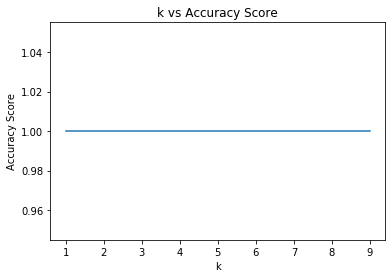

In [19]:
plt.plot(k_values, accuracy_scores_list) 
plt.xlabel('k') 
plt.ylabel('Accuracy Score') 
plt.title('k vs Accuracy Score') 
plt.show() 

### 2. Plot k vs F1 Score

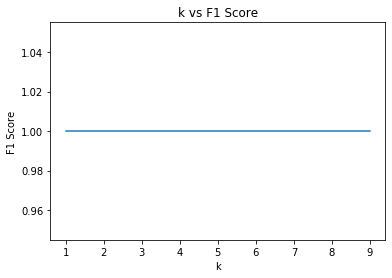

In [21]:
plt.plot(k_values, f1_scores_list) 
plt.xlabel('k') 
plt.ylabel('F1 Score') 
plt.title('k vs F1 Score') 
plt.show()

### Report for Test Data

In [15]:
knn_classifier = KNNClassifier()
knn_classifier.train('/home/jyoti/Documents/SMAI/assign1/q2/train.csv')
predictions_test = knn_classifier.predict('/home/jyoti/Documents/SMAI/assign1/q2/test.csv')
test_labels_test = list()
with open('/home/jyoti/Documents/SMAI/assign1/q2/test_labels.csv') as f:
  for line in f:
    test_labels_test.append(line.strip())

### 1. Accuracy Score

In [17]:
print (accuracy_score(test_labels_test, predictions_test))

1.0


### 2. F1 Score

In [22]:
print(f1_score(test_labels_test, predictions_test, average='micro', zero_division='warn'))

1.0


### 3. Confusion Matrix

In [23]:
print(confusion_matrix(test_labels_test, predictions_test))

[[505   0]
 [  0 495]]


### 4. Classification Report

In [24]:
print(classification_report(test_labels_test, predictions_test))

              precision    recall  f1-score   support

           e       1.00      1.00      1.00       505
           p       1.00      1.00      1.00       495

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



## Performance of Scikit-learn's Classifier

In [51]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
train_data_frm = pd.read_csv('/home/jyoti/Documents/SMAI/assign1/q2/train.csv', header=None)
train_data_frm = knn_classifier.prepare_data(train_data_frm)
train_labels = train_data_frm.iloc[:,0].values
train_data_frm = train_data_frm.iloc[:,1:]
train_d = knn_classifier.find_one_hot_encoding(train_data_frm).values
test_data_frm = pd.read_csv('/home/jyoti/Documents/SMAI/assign1/q2/test.csv', header=None)
test_data_frm = knn_classifier.prepare_data(test_data_frm)
test_d = knn_classifier.find_one_hot_encoding(test_data_frm).values

num_of_neigh = KNeighborsClassifier(n_neighbors=3)
num_of_neigh.fit(train_d, train_labels)
predictions_knn = num_of_neigh.predict(test_d)

### 1. Accuracy Score

In [53]:
print(accuracy_score(test_labels_test,predictions_knn))

1.0


### 2. F1 Score

In [54]:
print(f1_score(test_labels_test, predictions_knn, average='micro', zero_division='warn'))

1.0


### 3. Confusion Matrix

In [55]:
print(confusion_matrix(test_labels_test, predictions_knn))

[[505   0]
 [  0 495]]


### 4. Classification Report

In [56]:
print(classification_report(test_labels_test, predictions_knn))

              precision    recall  f1-score   support

           e       1.00      1.00      1.00       505
           p       1.00      1.00      1.00       495

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

